In [1]:
import importlib
import torch
import torch.nn as nn

import tensorflow as tf

import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import numpy as np
import cv2
import pandas as pd

import random

c:\Users\bunna\AppData\Local\Programs\Python\Python39\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.16) or chardet (5.1.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [2]:
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)

In [3]:
def split_dataset(x, y, valid_split=.2, test_split=.2):
    classes = np.unique(y)
    train_valid_split = round(len(classes)*(1-(valid_split+test_split)))
    valid_test_split = round(len(classes)*(1-test_split))

    train_classes = set(classes[:train_valid_split])
    valid_classes = set(classes[train_valid_split:valid_test_split])
    test_classes = set(classes[valid_test_split:])

    train = {i:[] for i in train_classes}
    valid = {i:[] for i in valid_classes}
    test = {i:[] for i in test_classes}

    for data, class_ in zip(x, y):
        if class_ in train_classes:
            train[class_].append(data)
        
        elif class_ in valid_classes:
            valid[class_].append(data)

        else:
            test[class_].append(data)

    for class_ in train_classes:
        train[class_] = np.stack(train[class_])

    for class_ in valid_classes:
        valid[class_] = np.stack(valid[class_])

    for class_ in test_classes:
        test[class_] = np.stack(test[class_])

    return train, valid, test

In [4]:
SIZE = 7

(x, y), (_, _) = tf.keras.datasets.mnist.load_data()
x = np.stack([cv2.resize(img/255.0, dsize=[SIZE, SIZE]) for img in x]).reshape(-1, SIZE**2)

_, mnist_valid, mnist_test = split_dataset(x, y, valid_split=.5, test_split=.5)

(x, y), (_, _) = tf.keras.datasets.fashion_mnist.load_data()
x = np.stack([cv2.resize(img/255.0, dsize=[SIZE, SIZE]) for img in x]).reshape(-1, SIZE**2)

_, fashion_valid, fashion_test = split_dataset(x, y, valid_split=.5, test_split=.5)

emnist = pd.read_csv("emnist-letters-train.csv").values
x, y = emnist[:, 1:], emnist[:, 0]
x = np.stack([cv2.resize(cv2.flip(cv2.rotate(img.reshape(28, 28)/255.0, cv2.ROTATE_90_CLOCKWISE), 1), dsize=[SIZE, SIZE]) for img in x]).reshape(-1, SIZE**2)

emnist_train, emnist_valid, emnist_test = split_dataset(x, y)

In [5]:
train = [emnist_train]
valid = [mnist_valid, fashion_valid, emnist_valid]

In [6]:
import ES.ES_classes
import ES.ES_NeuralGraph
importlib.reload(ES.ES_classes)
importlib.reload(ES.ES_NeuralGraph)

<module 'ES.ES_NeuralGraph' from 'c:\\Users\\bunna\\Documents\\GitHub\\NeuralGraphPaper\\ES\\ES_NeuralGraph.py'>

In [7]:
# Multiplication message fn

ch_n = 4
ch_e = 4

# class Message(ES.ES_classes.ES_MLP):
#     def __init__(self, sequential):
#         super().__init__(sequential)

#     def forward(self, x):
#         with torch.no_grad():
#             a = ES.ES_classes.expand_repeat(x, x.shape[-1], -1)
#             b = ES.ES_classes.expand_repeat(x, x.shape[-1], -2)
#             ab = (a * b).reshape(*x.shape[:-1], x.shape[-1]**2)
#             return self.sequential(ab)

# messages = nn.ModuleList([Message(nn.Sequential(
#     ES.ES_classes.ES_Linear((ch_n*2+ch_e)**2, 16),
#     nn.Tanh(),
#     ES.ES_classes.ES_Linear(16, 2*(ch_n)+(ch_e)),
# ))])

In [8]:
BATCH_SIZE = 512
# BATCH_SIZE = 32
TIME = 1
DT = .25

n_classes = 2
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"

shape = [SIZE**2, 8, n_classes]
n_nodes = sum(shape)
connections = torch.Tensor([[sum(shape[:i])+x, sum(shape[:i+1])+y] for i in range(len(shape)-1) for x in range(shape[i]) for y in range(shape[i+1])])

print(len(connections))

graph = ES.ES_NeuralGraph.NeuralGraph(n_nodes, SIZE**2, n_classes, connections,
    ch_n=ch_n, ch_e=ch_e, init_mode="trainable", init_std=.05, set_nodes=True,
    aggregation="mean", use_label=True, clamp_mode="hard", max_value=5).to(device)

log = []

408


In [139]:
EXAMPLES = 10

# Reset optimizer
optimizer = torch.optim.Adam(graph.parameters(), lr=0.01)
# optimizer = torch.optim.SGD(graph.parameters(), lr=0.025)
criterion = nn.MSELoss()

STEPS = 10_000

log = []

In [141]:
# graph.load_state_dict(torch.load("models/graph.pt"))

In [1]:
sigma = .025

with torch.no_grad():
    bar = tqdm(range(1, STEPS+1))
    for step in bar:

        # Train step
        x_train, y_train = torch.randn(BATCH_SIZE, EXAMPLES, 49).to(device), torch.randint(n_classes, (BATCH_SIZE, EXAMPLES)).to(device)

        # Memorization training:
        shuffle = torch.permute(torch.arange(BATCH_SIZE), (0,))
        x_test, y_test = x_train[shuffle], y_train[shuffle]

        y_input = nn.functional.one_hot(y_train, n_classes).float()
        y_label = nn.functional.one_hot(y_test, n_classes).float()

        graph.generate_epsilons(BATCH_SIZE, sigma=sigma)
        graph.init_vals(nodes=True, edges=True, batch_size=BATCH_SIZE)

        graph.learn(x_train, y_input, time=TIME, dt=DT, apply_once=True, reset_nodes=True, edges=False, edges_at_end=True)
        pred = graph.predict(x_test, time=TIME, dt=DT, apply_once=True, reset_nodes=True, edges=False)

        accs = (pred.argmax(2) == y_test).float().mean(-1)
        acc = accs.mean()

        task_losses = torch.square(pred - y_label).mean(-1).mean(-1)
        graph.estimate_grads(task_losses - accs, sigma=sigma)


        task_loss = task_losses.mean()
        overflow = graph.overflow()
        
        loss = task_loss + overflow
        optimizer.step()

        # Valid step (currently just validating with perturbations but could change to do not train_mode)
        x_train, y_train, x_test, y_test, classes = get_batch_data(dataset=valid)
        y_input = nn.functional.one_hot(y_train, n_classes).float()
        y_label = nn.functional.one_hot(y_test, n_classes).float()

        graph.init_vals(nodes=True, edges=True, batch_size=BATCH_SIZE)

        graph.learn(x_train, y_input, time=TIME, dt=DT, apply_once=True, reset_nodes=True, edges=False, edges_at_end=True)
        pred = graph.predict(x_test, time=TIME, dt=DT, apply_once=True, reset_nodes=True, edges=False)

        valid_acc = (pred.argmax(2) == y_test).float().mean()
        valid_loss = criterion(pred, y_label)

        entry = {'valid_loss':valid_loss.item(), 'valid_acc':valid_acc.item(), 'loss': task_loss.item(), 'acc': acc.item(), "overflow": overflow.item()}
        log.append(entry)
        bar.set_postfix({"valid_loss":np.mean([e["valid_loss"] for e in log[-10:]]), "valid_acc":np.mean([e["valid_acc"] for e in log[-10:]]), "loss":np.mean([e["loss"] for e in log[-10:]]), "acc":np.mean([e["acc"] for e in log[-10:]]), "overflow":entry["overflow"]})

NameError: name 'torch' is not defined

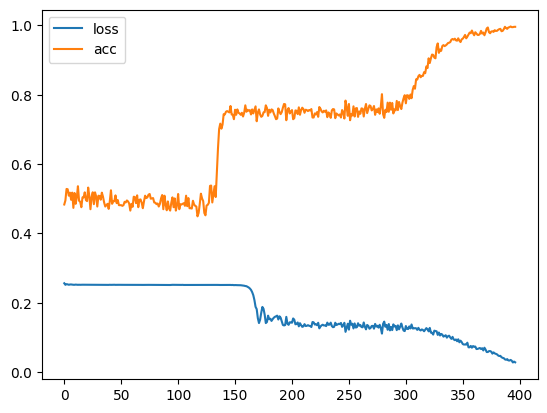

In [138]:
plt.plot([e["loss"] for e in log], label="loss")
plt.plot([e["acc"] for e in log], label="acc")
plt.legend()

In [12]:
EXAMPLES = 10

# Reset optimizer
optimizer = torch.optim.Adam(graph.parameters(), lr=0.01)
# optimizer = torch.optim.SGD(graph.parameters(), lr=0.025)
criterion = nn.MSELoss()

STEPS = 10_000

log = []

In [13]:
def shuffle_along_axis(a, axis):
    idx = np.random.rand(*a.shape).argsort(axis=axis)
    return np.take_along_axis(a,idx,axis=axis)

def get_batch_data(dataset=train, batch_size=BATCH_SIZE, train_examples=10, test_examples=10):
    if type(dataset) != list:
        dataset = [dataset]
    set_ = np.random.randint(len(dataset), size=(batch_size))

    classes = np.stack([np.random.choice(list(dataset[i].keys()), size=(n_classes), replace=False) for i in set_])
    
    # This gets completely random examples
    # y_train = np.random.randint(n_classes, size=(batch_size, train_examples))
    # y_test = np.random.randint(n_classes, size=(batch_size, TEST_EXAMPLES))

    # This gets balanced random examples
    
    y_train = np.repeat(np.expand_dims(np.round(np.linspace(0, n_classes-1, train_examples)), axis=0), batch_size, axis=0).astype(np.int32)
    y_test = np.repeat(np.expand_dims(np.round(np.linspace(0, n_classes-1, test_examples)), axis=0), batch_size, axis=0).astype(np.int32)

    y_train = shuffle_along_axis(y_train, axis=1)
    y_test = shuffle_along_axis(y_test, axis=1)

    x_train = []
    for batch_classes, y, i in zip(classes, y_train, set_):
        x_train.append([])
        for class_ in batch_classes[y]:
            x_train[-1].append(random.choice(dataset[i][class_]))
        x_train[-1] = np.stack(x_train[-1])
    x_train = np.stack(x_train)

    x_test = []
    for batch_classes, y, i in zip(classes, y_test, set_):
        x_test.append([])
        for class_ in batch_classes[y]:
            x_test[-1].append(random.choice(dataset[i][class_]))
        x_test[-1] = np.stack(x_test[-1])
    x_test = np.stack(x_test)
    
    return torch.Tensor(x_train).to(device), torch.Tensor(y_train).long().to(device), torch.Tensor(x_test).to(device), torch.Tensor(y_test).long().to(device), classes

In [14]:
sigma = .025

with torch.no_grad():
    bar = tqdm(range(1, STEPS+1))
    for step in bar:

        # Train step
        x, y, _, _, classes = get_batch_data(dataset=train, train_examples=EXAMPLES, test_examples=1)

        y_oh = nn.functional.one_hot(y, n_classes).float()

        graph.generate_epsilons(BATCH_SIZE, sigma=sigma)
        graph.init_vals(nodes=True, edges=True, batch_size=BATCH_SIZE)

        # Rolling evaluation: sorta like LM
        pred = []
        for i in range(EXAMPLES):
            pred.append(graph.forward(x[:, i], time=TIME, dt=DT, apply_once=True, edges=False))
            graph.backward(x[:, i], y_oh[:, i], time=TIME, dt=DT, apply_once=True, edges=False, edges_at_end=True)
            graph.init_vals(nodes=True, edges=False, batch_size=BATCH_SIZE)
        pred = torch.stack(pred, axis=1)

        accs = (pred.argmax(2) == y).float().mean(-1)
        acc = accs.mean()

        task_losses = torch.square(pred - y_oh).mean(-1).mean(-1)
        graph.estimate_grads(task_losses - accs, sigma=sigma)
        

        task_loss = task_losses.mean()
        overflow = graph.overflow()
        
        loss = task_loss + overflow
        optimizer.step()



        # Valid step (currently just validating with perturbations but could change to do not train_mode)
        x, y, _, _, classes = get_batch_data(dataset=valid, train_examples=EXAMPLES, test_examples=1)
        y_oh = nn.functional.one_hot(y, n_classes).float()

        graph.init_vals(nodes=True, edges=True, batch_size=BATCH_SIZE)

        pred = []
        for i in range(EXAMPLES):
            pred.append(graph.forward(x[:, i], time=TIME, dt=DT, apply_once=True, edges=False))
            graph.backward(x[:, i], y_oh[:, i], time=TIME, dt=DT, apply_once=True, edges=False, edges_at_end=True)
            graph.init_vals(nodes=True, edges=False, batch_size=BATCH_SIZE)
        pred = torch.stack(pred, axis=1)

        valid_acc = (pred.argmax(2) == y).float().mean()
        valid_loss = criterion(pred, y_oh)


        entry = {'valid_loss':valid_loss.item(), 'valid_acc':valid_acc.item(), 'loss': task_loss.item(), 'acc': acc.item(), "overflow": overflow.item()}
        log.append(entry)
        bar.set_postfix({"valid_loss":np.mean([e["valid_loss"] for e in log[-10:]]), "valid_acc":np.mean([e["valid_acc"] for e in log[-10:]]), "loss":np.mean([e["loss"] for e in log[-10:]]), "acc":np.mean([e["acc"] for e in log[-10:]]), "overflow":entry["overflow"]})

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [1:26:23<00:00,  1.93it/s, valid_loss=0.238, valid_acc=0.654, loss=0.238, acc=0.651, overflow=0]


In [162]:
torch.save(graph.state_dict(), "models/ES_graph.pt")

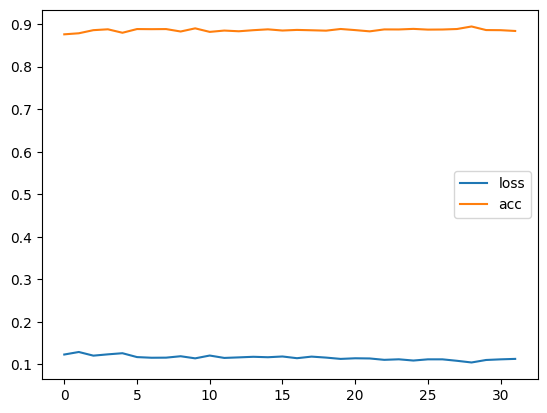

In [163]:
plt.plot([e["loss"] for e in log], label="loss")
plt.plot([e["acc"] for e in log], label="acc")
plt.legend()

In [167]:
with torch.no_grad():
    x, y, _, _, classes = get_batch_data(dataset=train, train_examples=EXAMPLES, test_examples=1)

    y_oh = nn.functional.one_hot(y, n_classes).float()

    graph.generate_epsilons(BATCH_SIZE, sigma=sigma)
    graph.init_vals(nodes=True, edges=True, batch_size=BATCH_SIZE)

    # Rolling evaluation: sorta like LM
    pred = []
    for i in range(EXAMPLES):
        pred.append(graph.forward(x[:, i], time=TIME, dt=DT, apply_once=True, edges=False))
        graph.backward(x[:, i], y_oh[:, i], time=TIME, dt=DT, apply_once=True, edges=False, edges_at_end=True)
        graph.init_vals(nodes=True, edges=False, batch_size=BATCH_SIZE)
    pred = torch.stack(pred, axis=1)

torch.Size([512, 1000])
torch.Size([512, 1000])


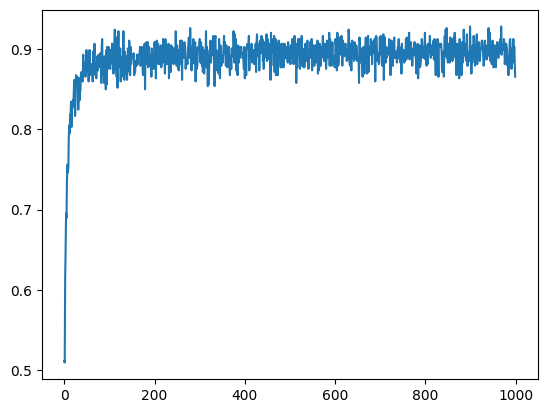

In [174]:
print(pred.argmax(-1).shape)
print(y.shape)

avg_acc = (pred.argmax(-1) == y).float().mean(0).cpu()

plt.plot(avg_acc)

tensor(5.)
tensor(-5.)


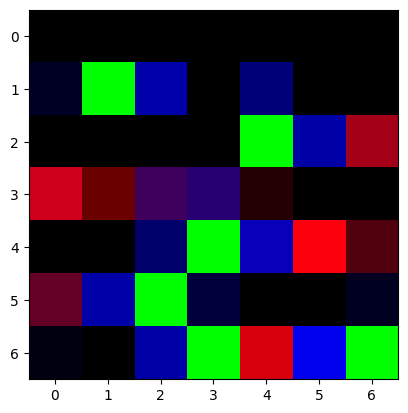

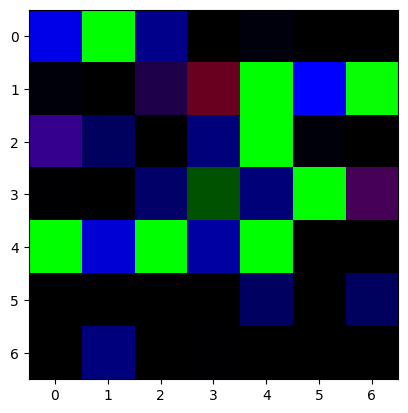

In [185]:
print(graph.edges[0].reshape(2, 7, 7, 4)[0, :, :, :3].cpu().max())
print(graph.edges[0].reshape(2, 7, 7, 4)[0, :, :, :3].cpu().min())

plt.imshow(graph.edges[0].reshape(2, 7, 7, 4)[0, :, :, :3].cpu() / 10 + .5)
plt.show()
plt.imshow(graph.edges[0].reshape(2, 7, 7, 4)[1, :, :, :3].cpu() / 10 + .5)
plt.show()

In [186]:
print(classes[0])

[3 6]
